In [14]:
import sys
PROJECT_PATH = "/home/mrcong/Code/mylab-nilm-files/nilm-physical-features"
sys.path.append(f"{PROJECT_PATH}/src/common")

import numpy as np
import polars as pl
from sklearn.metrics import classification_report
import os
from tqdm import tqdm

# for DL modeling
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from ann_models import AnnRMSModel, MLPModel2
import logging
from model_eval import ModelEvaluation
from utils import extract_features
from nilm_dao import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import argparse
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

eval_batch_size = 512
window_size = 1800
model_name = "mlp_['P'].pt"
is_norm = True
is_bn = True
dropout_rate = 0
data_type = "test"
dataset_name = "iawe"
size = 1

# Setup other things
model_eval = ModelEvaluation()
features = extract_features(model_name)

# Model path
if dataset_name == "vndale1":
    model_path = f"{PROJECT_PATH}/results/models/VNDALE1/window_{window_size}/{len(features)}_comb"
elif dataset_name == "iawe":
    model_path = f"{PROJECT_PATH}/results/models/iawe/{len(features)}_comb"
elif dataset_name == "rae":
    model_path = f"{PROJECT_PATH}/results/models/rae/{len(features)}_comb"
else:
    raise ValueError("Invalid dataset name!")

state_dict_path = f"{model_path}/{model_name}"

# Starting Main():
device = torch.device("cuda:0")
print(f"[+] Evaluation on {device} with model path: {state_dict_path}")

# Loading the data
print("[+] Loading data:")
if dataset_name == "vndale1":
    validation_df = get_vndale1_data(data_type, window_size, is_norm)
elif dataset_name == "iawe":
    validation_df = get_iawe_data(data_type, is_norm)
elif dataset_name == "rae":
    validation_df = get_rae_data(data_type, is_norm)
else:
    raise ValueError("Invalid dataset name!")
print(validation_df.head())
label_encoder = get_label_encoder(dataset_name)

# Transform X_train and X_val to numpy
print("[+] Transform into numpy:")
X_val = validation_df.select(features).to_numpy()
y_val = validation_df["Label"].to_numpy()
if size < 1.0:
    X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=size, random_state=42, stratify=y_val)
no_classes = len(label_encoder.classes_)

# Change X, y to tensors, and setup
print("[+] Dataset information:")
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val)
print(f"[+] Validation set: {X_val.shape}, y_val: {y_val.shape}")

# Load the model
ann_rms = AnnRMSModel(input_dim=len(features), output_dim=no_classes, is_bn=is_bn, dropout=dropout_rate)
ann_rms.to(device)

# Load the previous model
if os.path.isfile(state_dict_path):
    logging.info(f"[+] Model load in : {state_dict_path}")
    ann_rms.load_state_dict(torch.load(state_dict_path))
    logging.info(f"[+] Model loaded!")
else:
    logging.error("[+] Model path not found!")
    exit()

# Train and validation dataloaders
val_dataDataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataDataset, batch_size=eval_batch_size, shuffle=True, drop_last=False, num_workers=12, pin_memory=True, persistent_workers=True)

def get_embedding(model: AnnRMSModel, x):
    model.eval()
    with torch.no_grad():
        if not model.is_bn:
            x = F.relu(model.input(x))
            x = model.do1(x)
            x = F.relu(model.fc1(x))
            x = model.do2(x)
            x = F.relu(model.fc2(x))
            x = model.do3(x)
            x = F.relu(model.fc3(x))
            x = model.do4(x)
            x = F.relu(model.fc4(x))
            x = model.do5(x)
            x = F.relu(model.fc5(x))
            x = model.do6(x)
            x = F.relu(model.fc6(x))
            x = model.do6(x)
        else:
            x = model.bn_input(F.relu(model.input(x)))
            x = model.do1(x)
            x = model.bn1(F.relu(model.fc1(x)))
            x = model.do2(x)
            x = model.bn2(F.relu(model.fc2(x)))
            x = model.do3(x)
            x = model.bn3(F.relu(model.fc3(x)))
            x = model.do4(x)
            x = model.bn4(F.relu(model.fc4(x)))
            x = model.do5(x)
            x = model.bn5(F.relu(model.fc5(x)))
            x = model.do6(x)
            x = model.bn6(F.relu(model.fc6(x)))
            x = model.do6(x)
    return x

# Function to get embeddings
def get_embeddings_dataset(device, model, test_loader):
    embeddings_list = []
    for X, _ in tqdm(iterable=test_loader, desc="Extracting embeddings"):
        X = X.to(device)
        embeddings = get_embedding(model, X)
        embeddings_list.extend(embeddings.cpu().numpy())
    return np.array(embeddings_list)

# Getting embeddings
print("[+] Getting embeddings:")
embeddings = get_embeddings_dataset(device=device, model=ann_rms, test_loader=val_loader)
print(f"[+] Embeddings shape: {embeddings.shape}")

/tmp/ipykernel_87553/2914271486.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_rms.load_state_dict(torch.load(state_dict_path))


[+] Evaluation on cuda:0 with model path: /home/mrcong/Code/mylab-nilm-files/nilm-physical-features/results/models/iawe/1_comb/mlp_['P'].pt
[+] Loading data:
shape: (5, 7)
┌────────────┬───────────┬───────────┬──────────┬───────────┬───────────┬───────┐
│ unix_ts    ┆ Irms      ┆ P         ┆ MeanPF   ┆ Q         ┆ S         ┆ Label │
│ ---        ┆ ---       ┆ ---       ┆ ---      ┆ ---       ┆ ---       ┆ ---   │
│ i64        ┆ f64       ┆ f64       ┆ f64      ┆ f64       ┆ f64       ┆ i64   │
╞════════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════╡
│ 1373458412 ┆ -0.331477 ┆ -0.338762 ┆ 0.129856 ┆ -0.623708 ┆ -0.367706 ┆ 9     │
│ 1373458422 ┆ -0.331477 ┆ -0.339605 ┆ 0.129307 ┆ -0.623758 ┆ -0.368476 ┆ 9     │
│ 1373458432 ┆ -0.3311   ┆ -0.339813 ┆ 0.129388 ┆ -0.623197 ┆ -0.368713 ┆ 9     │
│ 1373458443 ┆ -0.331855 ┆ -0.340138 ┆ 0.129289 ┆ -0.622974 ┆ -0.369035 ┆ 9     │
│ 1373458453 ┆ -0.330723 ┆ -0.341117 ┆ 0.131333 ┆ -0.616015 ┆ -0.3705   ┆ 9     │
└───────

Extracting embeddings:   0%|          | 0/784 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████| 784/784 [00:01<00:00, 543.77it/s]


[+] Embeddings shape: (401287, 160)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from nilm_dao import *
import umap
from sklearn.model_selection import train_test_split

y_val = validation_df["Label"].to_numpy()
y_val = label_encoder.inverse_transform(y_val)
X_visulization, _, y_visulization, _ = train_test_split(embeddings, y_val, train_size=0.3, random_state=42, stratify=y_val)
print(f"[+] Visualization data: {X_visulization.shape}, {y_visulization.shape}")

[+] Visualization data: (120386, 160), (120386,)


/opt/miniconda3/envs/mylab-nilm-env/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/miniconda3/envs/mylab-nilm-env/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/miniconda3/envs/mylab-nilm-env/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/miniconda3/envs/mylab-nilm-env/lib/python3.12/site-packages/umap/spectral.

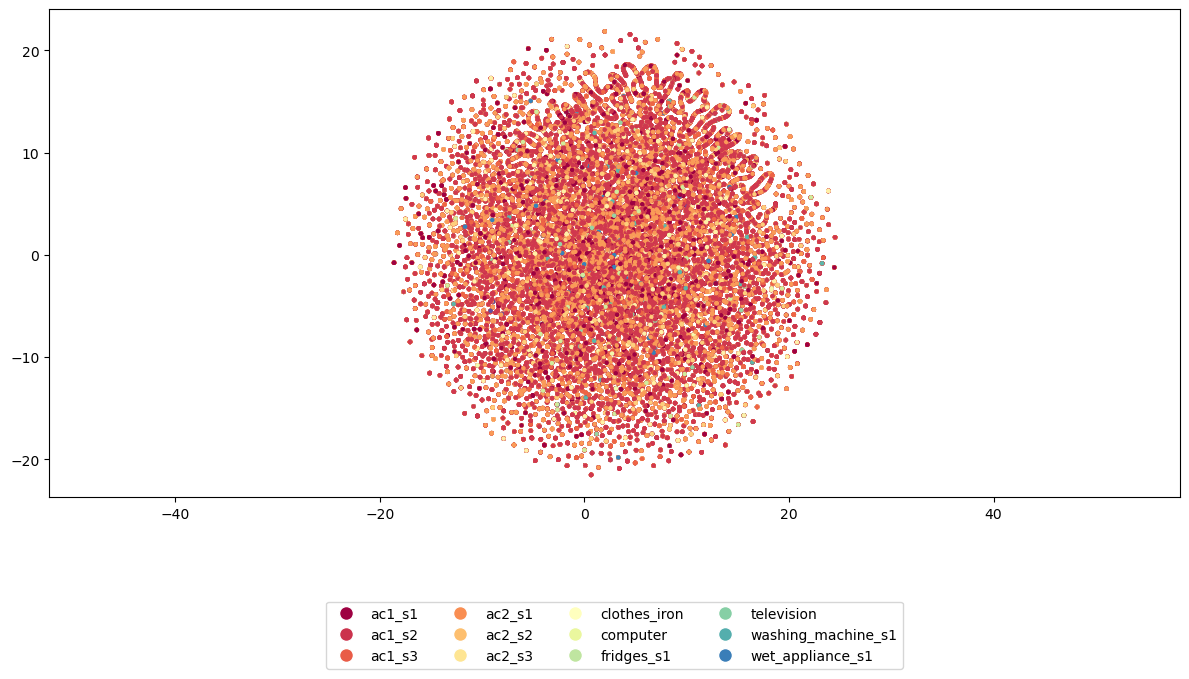

In [ ]:
plt.figure(figsize=(12, 7))  # Reduced width from 18 to 12
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(X_visulization, verbose=True)

unique_labels = np.unique(y_val)
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=pd.factorize(y_visulization)[0], cmap="Spectral", s=2)
plt.gca().set_aspect("equal", "datalim")
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Spectral(i/len(unique_labels)), 
                              label=unique_labels[i], markersize=10) for i in range(len(unique_labels))]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)
plt.tight_layout()
plt.show()

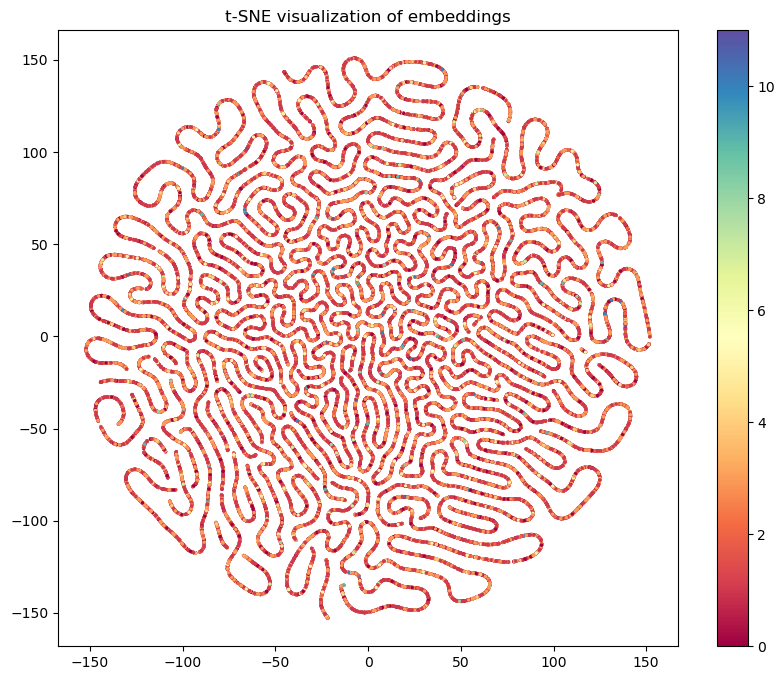

In [20]:
# Visualize the embeddings using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
X_visualization_2d = tsne.fit_transform(X_visulization)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_visualization_2d[:, 0], X_visualization_2d[:, 1], c=pd.factorize(y_visulization)[0], cmap='Spectral', s=2)
plt.colorbar()
plt.title("t-SNE visualization of embeddings")
plt.show()